#utility NB for clustering lecture UI class 10
#FBB November 2015

In [1]:
__author__ = 'fbb'
%pylab inline
import numpy as np
import pylab as pl
#import kmseg
import sklearn.cluster
from sklearn import mixture
from PIL import Image
from scipy.misc import imread
from scipy.cluster.vq import kmeans2
import json
import os
s = json.load( open(os.getenv ('PUI2015')+"/fbb_matplotlibrc.json") )
pl.rcParams.update(s)

kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

Populating the interactive namespace from numpy and matplotlib


/Users/JianhaoZhou/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/JianhaoZhou/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


#THANKGSIVING TWEET CLUSTERING ANALYSIS

In [2]:
import pandas as pd
from scipy.cluster.vq import whiten
import datetime as dt


In [3]:
tweets = json.load(open("tweetsnew.txt"))

In [4]:
dt.datetime.strptime(' 2015-11-27 17:59:32 ', " %Y-%m-%d %H:%M:%S ")
lon, lat, timestamp  = [], [], []
for k,tw in enumerate(tweets.iterkeys()):
    #print k, tweets[tw]['coords']['coordinates'][0]
    lon.append(tweets[tw]['coords']['coordinates'][0])
    lat.append(tweets[tw]['coords']['coordinates'][1])
    timestamp.append(dt.datetime.strptime(tweets[tw]['date'],"%Y-%m-%d %H:%M:%S"))
#print lon,lat,timestamp

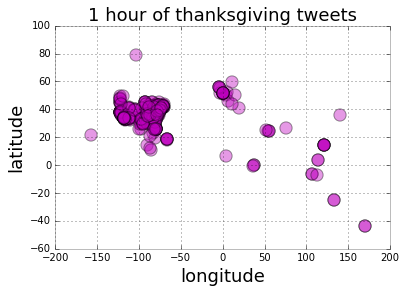

In [5]:
ax = pl.figure().add_subplot(111)
rs_scatter = ax.scatter(lon,lat, c='m', edgecolor='k', alpha=.4, s=150)
pl.xlabel("longitude", fontsize=18)
pl.ylabel("latitude", fontsize=18)
pl.title("1 hour of thanksgiving tweets", fontsize=18)

In [6]:
import pandas as pd
import json, requests
def reverseGeocode(latlng):
    result = {}
    print latlng
    url = 'https://maps.googleapis.com/maps/api/geocode/json?latlng={0}&key={1}'
    apikey = os.getenv("GOOGLEAPI")
    print apikey
    request = url.format(latlng, apikey)
    print request
    data = json.loads(requests.get(request).text)
    if len(data['results']) > 0:
        result = data['results'][0]
    #print result
    return result

In [11]:
df = pd.DataFrame()
df['lat'] = np.array(lat)
df['lon'] = np.array(lon)
df['ts'] = np.array(timestamp)
df.head()
# print df['lat'][0], df['lon']

,lat,lon,ts
0,40.756510,-73.997426,2015-11-27 17:40:10
1,30.267200,-97.763900,2015-11-27 18:17:02
2,38.901815,-77.037336,2015-11-27 17:40:02
3,-6.239873,106.785846,2015-11-27 17:39:54
4,32.874180,-117.216133,2015-11-27 17:40:19


##adding city and country info by reverse geocoding coordinates with Google API

In [8]:
df['country'] = np.array(['']*len(df.lon))
df['city'] = np.array(['']*len(df.lon))

In [9]:
for k in range(len(df.lon)):
    ll = df.lat[k].astype('str')+','+df.lon[k].astype('str')
    #print reverseGeocode(ll)['address_components']
    address_components = reverseGeocode(ll)['address_components']
    for component in address_components:
        #print component['types']
        if 'country' in component['types']:
            df['country'][k] = component['long_name']
            #print component['long_name']
        #now try to identify the municipality
    for component in address_components:
            if 'locality' in component['types']:
                df['city'][k] = component['long_name']
                break
            elif 'postal_town' in component['types']:
                df['city'][k] = component['long_name']
                break
            elif 'administrative_area_level_2' in component['types']:
                df['city'][k] = component['long_name']
                break
            elif 'administrative_area_level_1' in component['types']:
                df['city'][k] = component['long_name']
                break
df.to_csv('geocoded.csv', encoding='utf-8', index=False)


40.75651005,-73.99742555
None
https://maps.googleapis.com/maps/api/geocode/json?latlng=40.75651005,-73.99742555&key=None


KeyError: 'address_components'

In [ ]:
df.head()

In [ ]:
df.size

In [ ]:
coordinates = df.as_matrix(columns=['lon', 'lat'])
D = len(coordinates[0])
N = len(coordinates)
print "number of features: ", D
print "number of data points: ", N


##important: you must "whiten" your data before clustering: you are standardizing the data along the features

In [ ]:
w = whiten(coordinates)

In [ ]:
print coordinates.mean(axis=0), w.mean(axis=0)
print coordinates.std(axis=0), w.std(axis=0)


In [ ]:
# k means cluster results depend on the starting point, which is random!
nk= 5
for i in range(5):
    cluster_centroids, closest_centroids = kmeans2(w, nk, iter=1)
    pl.figure(figsize=(10, 6))
    pl.scatter(cluster_centroids[:,0], cluster_centroids[:,1], c='r', s=100)
    pl.scatter(w[:,0], w[:,1], c='k', alpha=.3, s=10)
    pl.xlabel("longitude", fontsize=18)
    pl.ylabel("latitude", fontsize=18)
    pl.title("K-means clustering, %d culsters"%nk, fontsize=18)


In [ ]:
#a function to get N different colors from a colormap given an array size N
def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))

#get the cluster centers
cluster_centroids, closest_centroids = kmeans2(w, nk, iter=1, minit='points')
colors = get_colors(closest_centroids, pl.cm.jet)
colorsc = get_colors(np.arange(nk), pl.cm.jet)


In [ ]:
plt.figure(figsize=(10, 6), dpi=100)
print [sum(closest_centroids == i) for i in range(nk)]
plt.scatter(cluster_centroids[:,0], cluster_centroids[:,1], c=colorsc, alpha=.3, 
            s=np.array([sum(closest_centroids == i) for i in range(k)])*100)

pl.scatter(w[:,0], w[:,1], c=colors, s=30)
pl.xlabel("longitude", fontsize=18)
pl.ylabel("latitude", fontsize=18)
pl.title("K-means clustering, 5 culsters, better initialization", fontsize=18)


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import geopy
from geopy.distance import great_circle
#df = pd.read_csv('summer-travel-gps-full.csv')
coordinates = df.as_matrix(columns=['lon', 'lat'])
w = whiten(coordinates)

In [ ]:
db = DBSCAN(eps=0.8, min_samples=2).fit(w)
labels = (db.labels_).astype(int)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
clusters = pd.Series([coordinates[labels == i] for i in xrange(num_clusters)])
print('Number of clusters: %d' % num_clusters)


In [ ]:
#functio to get the centroid from DBscan as mean of cluster members
def getCentroid(points):
    #print points[:,0], np.nanmean(points[:,0])
    return np.nanmean(points[:,0]), np.nanmean(points[:,1])


In [ ]:
centroids = np.zeros((num_clusters,2))

for i in labels:
    centroids[i] = getCentroid(coordinates[labels == i])#
colorsc2 = get_colors(np.arange(num_clusters), pl.cm.jet)

plt.figure(figsize=(10, 6), dpi=100)
for i in np.unique(labels):
    if int(i) == -1:
        continue
    plt.scatter(centroids[i,0], centroids[i,1], c=colorsc2[i], alpha=.3, 
                s=sum(labels == i)*100, 
                label=["%i"%i])
#pl.legend(numpoints=1, scatterpoints=1)
colors2 = get_colors(labels, pl.cm.jet)

pl.scatter(coordinates[:,0], coordinates[:,1], c=colors2, s=20)
pl.scatter(coordinates[:,0][labels==-1], coordinates[:,1][labels==-1], c='k', alpha=0.4, s=300)
pl.xlabel("longitude", fontsize=18)
pl.ylabel("latitude", fontsize=18)
pl.title("DBscan clustering, %d culsters, %d outliers"%(num_clusters, sum(labels == -1)), fontsize=18)


In [ ]:
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering(n_clusters=5,  compute_full_tree=True).fit(w)
labelsag = agc.labels_


In [ ]:
centroidsag = np.zeros((5,2))

colorsc3 = get_colors(np.arange(5), pl.cm.jet)
colors3 = get_colors(labelsag, pl.cm.jet)
for i in labelsag:
    centroidsag[i] = getCentroid(coordinates[labelsag == i])
 
pl.figure(figsize=(10, 6), dpi=100)
pl.scatter(centroidsag[:,0], centroidsag[:,1], c=colorsc3, alpha=.3, 
            s=np.array([sum(labelsag == i) for i in range(5)])*100)
 
pl.scatter(coordinates[:,0], coordinates[:,1], c=colors3, s=10)
pl.xlabel("longitude", fontsize=18)
pl.ylabel("latitude", fontsize=18)
pl.title("Agglomerative clustering, ward linkage, 5 culsters", fontsize=18)


In [ ]:
agc = AgglomerativeClustering(n_clusters=5,  linkage='average', 
                              compute_full_tree=True).fit(w)
labelsag = agc.labels_
centroidsag = np.zeros((5,2))

colorsc3 = get_colors(np.arange(5), pl.cm.jet)
colors3 = get_colors(labelsag, pl.cm.jet)
for i in labelsag:
    centroidsag[i] = getCentroid(coordinates[labelsag == i])
    
pl.figure(figsize=(10, 6), dpi=100)
pl.scatter(centroidsag[:,0], centroidsag[:,1], c=colorsc3, alpha=.3, 
            s=np.array([sum(labelsag == i) for i in range(5)])*100)
 
pl.scatter(coordinates[:,0], coordinates[:,1], c=colors3, s=30)
pl.xlabel("longitude", fontsize=18)
pl.ylabel("latitude", fontsize=18)
pl.title("Agglomerative clustering, average linkade, 5 culsters", fontsize=18)


##Using great circle distance. notice, this is important: we cannot whiten the data and then use the great circle geometry, because that is based on 179 and -179 being near each other, and whiteining the data will change those values!

In [ ]:
def geo_affinity(M):
    pl.imshow(np.log(np.array([[great_circle(a[-1::-1],
                        b[-1::-1]).miles for a in M] for b in M])), 
              interpolation='nearest', cmap='bone')
    pl.grid(False)
    pl.colorbar()
    #print M
    #print (np.array([[great_circle(a[-1::-1],b[-1::-1]).miles for a in M] for b in M]))
    return (np.array([[great_circle(a[-1::-1],b[-1::-1]).miles for a in M] for b in M]))

def linear_affinity(M, indx1=None, indx2=None, cb=True):
    d = np.log(np.array([[np.sum(np.abs(a[-1::-1]-
                        b[-1::-1])) for a in M] for b in M]))
    if indx1 and indx2:
        d = d[idx1,:]
        d = d[:,idx2]
    pl.imshow(d, 
              interpolation='nearest', cmap='bone')
    pl.grid(False)
    if cb: pl.colorbar()
    #print M
    #print (np.array([[great_circle(a[-1::-1],b[-1::-1]).miles for a in M] for b in M]))
    return (np.array([[great_circle(a[-1::-1],b[-1::-1]).miles for a in M] for b in M]))

In [ ]:
agc = AgglomerativeClustering(n_clusters=5,  
                              linkage='average', 
                              affinity=geo_affinity).fit(coordinates)
labelsag = agc.labels_
centroidsag = np.zeros((5,2))

colorsc3 = get_colors(np.arange(5), pl.cm.jet)
colors3 = get_colors(labelsag, pl.cm.jet)
for i in labelsag:
    centroidsag[i] = getCentroid(coordinates[labelsag == i])

pl.figure(figsize=(10, 6), dpi=100)
pl.scatter(centroidsag[:,0], centroidsag[:,1], c=colorsc3, alpha=.3, 
            s=np.array([sum(labelsag == i) for i in range(5)])*100)
 
pl.scatter(coordinates[:,0], coordinates[:,1], c=colors3, s=30)
pl.xlabel("longitude", fontsize=18)
pl.ylabel("latitude", fontsize=18)
pl.title("Agglomerative clustering, average, grate circle distance, 5 culsters", fontsize=18)

In [ ]:
agc = AgglomerativeClustering(n_clusters=30,  
                              linkage='average', 
                              affinity=geo_affinity).fit(coordinates)
labelsag = agc.labels_
centroidsag = np.zeros((30,2))

colorsc3 = get_colors(np.arange(30), pl.cm.jet)
colors3 = get_colors(labelsag, pl.cm.jet)
for i in labelsag:
    centroidsag[i] = getCentroid(coordinates[labelsag == i])

pl.figure(figsize=(10, 6), dpi=100)
#print [sum(labelsag == i) for i in range(30)]
pl.scatter(centroidsag[:,0], centroidsag[:,1], c=colorsc3, alpha=.3, 
            s=np.array([sum(labelsag == i) for i in range(30)])*100)
 
pl.scatter(coordinates[:,0], coordinates[:,1], c=colors3, s=10)
pl.xlabel("longitude", fontsize=18)
pl.ylabel("latitude", fontsize=18)
pl.title("Agglomerative clustering, averge, 30 culsters", fontsize=18)

dfc = pd.DataFrame()
dfc['lon'] = centroidsag[:,0]
dfc['lat'] = centroidsag[:,1]
dfc['size'] = np.array([sum(labelsag == i) for i in range(30)])*100

dfc.to_csv('thanksgivingclusters.csv', encoding='utf-8', index=False)

In [ ]:
import scipy.cluster as scp
fig = pl.figure(figsize=(10,10))
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(w, method='ward'),
                               labels = df.city.values,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels)
#pl.xticks(rotation=90)
pl.grid('off')

In [ ]:
fig = pl.figure(figsize=(10,10))

ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(w, method='ward'),
                               labels = df.city.values,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=20, truncate_mode='lastp', p=12, 
                               show_contracted=True, color_threshold = 2, 
                               orientation='right', above_threshold_color='k'
                              )  # font size for the x axis labels)
#pl.xticks(rotation=90)
pl.xlabel("distance", fontsize=20)
pl.grid('off')
#scp.hierarchy.dendrogram?


In [ ]:
pl.figure()
linear_affinity(coordinates)
pl.figure()
geo_affinity(coordinates)

In [ ]:
fig = pylab.figure(figsize=(8,8))

# Compute and plot first dendrogram.
ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
Y1 = scp.hierarchy.linkage(w, method='average')
Z1 = scp.hierarchy.dendrogram(Y, orientation='right')
ax1.set_xticks([])
ax1.set_yticks([])

# Compute and plot second dendrogram.
ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Y2 = scp.hierarchy.linkage(w, method='ward')
Z2 = scp.hierarchy.dendrogram(Y)
ax2.set_xticks([])
ax2.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
indx1 = Z1['leaves']
indx2 = Z2['leaves']

linear_affinity(coordinates, indx1=indx1, indx2=indx2, cb=False)
axmatrix.set_xticks([])



In [ ]:
#retrieveing the scipy cluster
from scipy.cluster.hierarchy import fcluster
max_d = 1.5
clusters = fcluster(Y1, max_d, criterion='distance')
pl.figure(figsize=(10, 6), dpi=150)
plt.scatter(coordinates[:,0], coordinates[:,1], c=clusters, )  # plot points with cluster dependent colorsclusters = fcluster(Y1, max_d, criterion='distance')
clusters = fcluster(Y2, max_d, criterion='distance')
pl.figure(figsize=(10, 6), dpi=150)
plt.scatter(coordinates[:,0], coordinates[:,1], c=clusters, )  # plot points with cluster dependent colors


##put it on a map

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt


In [ ]:
nk= 5
cluster_centroids, closest_centroids = kmeans2(w, nk, iter=i)
pl.figure(figsize=(10, 6))
pl.scatter(cluster_centroids[:,0]*coordinates.std(axis=0)[0], cluster_centroids[:,1]*coordinates.std(axis=0)[1], c='r', s=100)
pl.scatter(coordinates[:,0],coordinates[:,1], c='k', alpha=.3, s=10)
pl.xlabel("longitude", fontsize=18)
pl.ylabel("latitude", fontsize=18)
pl.title("K-means clustering, %d culsters"%nk, fontsize=18)
m = Basemap(width=12000000,height=9000000,projection='cyl',
            resolution=None,lat_1=-90,lat_2=90,lat_0=0,lon_0=0.)
m.shadedrelief()

In [ ]:
pl.figure(figsize=(20,20))
pl.scatter(centroidsag[:,0], centroidsag[:,1], c=colorsc3, alpha=.5, 
            s=np.array([sum(labelsag == i) for i in range(30)])*100)
 
pl.scatter(coordinates[:,0], coordinates[:,1], c=colors3, s=10)
pl.xlabel("longitude", fontsize=18)
pl.ylabel("latitude", fontsize=18)
pl.title("Agglomerative clustering, averge, 30 culsters", fontsize=18)
# setup Lambert Conformal basemap.
# set resolution=None to skip processing of boundary datasets.
m = Basemap(width=12000000,height=9000000,projection='cyl',
            resolution=None,lat_1=-90,lat_2=90,lat_0=0,lon_0=0.)
m.shadedrelief()

#and you can of course get fancier: 
https://nyu.cartodb.com/u/fb55/viz/e7315426-8d39-11e5-93b0-0ef7f98ade21/map

http://cosmo.nyu.edu/~fb55/vizs/clustermap.html
    

#note on great circle distance: the earth is round...


In [ ]:
#print great_circle(coordinates[0],coordinates,[coordinates[0],41.6713905 ]).miles
print great_circle([0,40][-1::-1],[2,40][-1::-1])
print great_circle([-179,40][-1::-1],[179,40][-1::-1])
print great_circle([-179,40][-1::-1],[179,-40][-1::-1])
print great_circle([-179,0][-1::-1],[-1,0][-1::-1])

In [ ]:
mockcoordinates = np.array([[0,40],[2,40],
                            [-169,40],[169,40],
                            [-165,40],[165,40]])
for i,m in enumerate(mockcoordinates[:-2]):
        print m, mockcoordinates[i+1], great_circle(m[-1::-1], mockcoordinates[i+1][-1::-1])
print geo_affinity(mockcoordinates)

In [ ]:
nk = 2
agc = AgglomerativeClustering(n_clusters=nk,  
                              linkage='average', 
                              affinity='euclidean').fit(mockcoordinates)
labelsag = agc.labels_
centroidsag = np.zeros((2,2))
colors = ['SteelBlue','IndianRed']
colors4 = get_colors(labelsag, pl.cm.jet)

for i in labelsag:
    centroidsag[i] = getCentroid(mockcoordinates[labelsag == i])
    
pl.figure(figsize=(10, 6), dpi=100)
pl.scatter(centroidsag[:,0], centroidsag[:,1], c=colors, alpha=0.5, 
            s=np.array([sum(labelsag == i) for i in range(2)])*300)
 
pl.scatter(mockcoordinates[:,0], mockcoordinates[:,1], c=colors4, s=50)
pl.xlabel("longitude", fontsize=18)
pl.ylabel("latitude", fontsize=18)
pl.title("Agglomerative clustering, average linkage, 2 culsters", fontsize=18)
m = Basemap(width=12000000,height=9000000,projection='cyl',
            resolution=None,lat_1=-90,lat_2=90,lat_0=0,lon_0=0.)
m.shadedrelief()

In [ ]:
agc_geo = AgglomerativeClustering(n_clusters=2,  
                              linkage='average', 
                              affinity=geo_affinity).fit(mockcoordinates)
labelsag = agc_geo.labels_
centroidsag = np.zeros((2,2))
colors4 = get_colors(labelsag, pl.cm.jet)

for i in labelsag:
    centroidsag[i] = getCentroid(mockcoordinates[labelsag == i])
    
pl.figure(figsize=(10, 6), dpi=100)
pl.scatter(centroidsag[:,0], centroidsag[:,1], c=colors, alpha=0.5, 
            s=np.array([sum(labelsag == i) for i in range(2)])*300)
 
pl.scatter(mockcoordinates[:,0], mockcoordinates[:,1], c=colors4, s=50)
pl.xlabel("longitude", fontsize=18)
pl.ylabel("latitude", fontsize=18)
pl.title("Agglomerative clustering, average linkage,\ngreat circle distance, 2 culsters", fontsize=18)
m = Basemap(width=12000000,height=9000000,projection='cyl',
            resolution=None,lat_1=-90,lat_2=90,lat_0=0,lon_0=0.)
m.shadedrelief()